In [1]:
import os
import numpy as np
import pandas as pd
from itertools import groupby
from astropy.io import fits

from lvmdrp import path, __version__ as drpver
from lvmdrp.utils import metadata as md
from lvmdrp.functions import run_drp as drp
from lvmdrp.functions import run_quickdrp as qdrp

from lvmdrp.functions import imageMethod


ORIG_MASTER_DIR = os.getenv("LVM_MASTER_DIR")

In [2]:
# define target MJD
MJD = 60146
# define corresponding masters path
masters_mjd = qdrp.get_master_mjd(MJD)
masters_path = os.path.join(ORIG_MASTER_DIR, f"{masters_mjd}")
print(masters_path)

/home/mejia/Research/lvm/lvmdata/calib/60142


In [3]:
# pull all frames' metadata
frames_table = md.get_metadata(kind="raw", tileid="*", mjd=MJD)
# filter dark frames
darks = frames_table.query("imagetyp == 'dark'")
darks

[INFO]: loading metadata store at /home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60146/raw_metadata.hdf5
[INFO]: found 747 frames in store '/home/mejia/Research/lvm/lvmdata/sas/sdsswork/lvm/spectro/redux/0.1.1.dev0/1111/60146/raw_metadata.hdf5'
[INFO]: number of frames after filtering 747
[INFO]: total number of frames found 747


,hemi,tileid,mjd,rmjd,imagetyp,spec,camera,expnum,exptime,neon,...,xenon,argon,ldls,quartz,quality,qual,stage,status,drpqual,name
6,s,1111,60146,60146,dark,sp2,b2,1531,300.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b2-00001531.fits
7,s,1111,60146,60146,dark,sp1,b1,1496,3600.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b1-00001496.fits
11,s,1111,60146,60146,dark,sp1,z1,1495,3600.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z1-00001495.fits
16,s,1111,60146,60146,dark,sp2,r2,1497,900.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r2-00001497.fits
19,s,1111,60146,60146,dark,sp2,b2,1467,300.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b2-00001467.fits
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,s,1111,60146,60146,dark,sp2,b2,1533,300.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-b2-00001533.fits
734,s,1111,60146,60146,dark,sp2,z2,1469,300.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-z2-00001469.fits
737,s,1111,60146,60146,dark,sp2,r2,1533,300.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r2-00001533.fits
744,s,1111,60146,60146,dark,sp3,r3,1469,300.0,False,...,False,False,False,False,excellent,0,1,0,0,sdR-s-r3-00001469.fits


In [4]:
# define target folder for detrended darks
target_dir = "data_pixmask"
os.makedirs(target_dir, exist_ok=True)

ddark_paths = []
for dark in darks.to_dict("records"):
    dark_path = path.full("lvm_raw", camspec=dark["camera"], **dark)
    # print(dark_path)
    
    # output path
    cam = dark["camera"]
    exp = dark["expnum"]
    ddark_path = os.path.join(target_dir, f"lvm-ddark-{cam}-{exp:>08d}.fits")
    ddark_paths.append(ddark_path)

    if os.path.isfile(ddark_path):
        print(f"skipping {ddark_path}, file already exist")
        continue
    
    # calib paths
    mbias_path = os.path.join(masters_path, f"lvm-mbias-{cam}.fits")
    
    imageMethod.preproc_raw_frame(in_image=dark_path, out_image=ddark_path, replace_with_nan=False)
    imageMethod.detrend_frame(in_image=ddark_path, out_image=ddark_path, in_bias=mbias_path, convert_to_e=False, reject_cr=False, replace_with_nan=False)

skipping data_pixmask/lvm-ddark-b2-00001531.fits, file already exist
skipping data_pixmask/lvm-ddark-b1-00001496.fits, file already exist
skipping data_pixmask/lvm-ddark-z1-00001495.fits, file already exist
skipping data_pixmask/lvm-ddark-r2-00001497.fits, file already exist
skipping data_pixmask/lvm-ddark-b2-00001467.fits, file already exist
skipping data_pixmask/lvm-ddark-z3-00001533.fits, file already exist
skipping data_pixmask/lvm-ddark-r2-00001501.fits, file already exist
skipping data_pixmask/lvm-ddark-z3-00001497.fits, file already exist
skipping data_pixmask/lvm-ddark-r3-00001531.fits, file already exist
skipping data_pixmask/lvm-ddark-z3-00001496.fits, file already exist
skipping data_pixmask/lvm-ddark-z3-00001457.fits, file already exist
skipping data_pixmask/lvm-ddark-z2-00001499.fits, file already exist
skipping data_pixmask/lvm-ddark-r3-00001499.fits, file already exist
skipping data_pixmask/lvm-ddark-b1-00001467.fits, file already exist
skipping data_pixmask/lvm-ddark-b2

In [5]:
darks["ddark_path"] = ddark_paths
cam_groups = darks.groupby(["camera", "exptime"])
for cam, exptime in cam_groups.groups:
    ddark_paths_cam = cam_groups.get_group((cam, exptime))["ddark_path"]
    
    # define output combined dark path
    mdark_path = os.path.join(target_dir, f"lvm-mdark-{cam}-{int(exptime)}s.fits")
    if os.path.isfile(mdark_path):
        print(f"skipping {mdark_path}, file already exist")
        continue
    
    imageMethod.create_master_frame(in_images=ddark_paths_cam, out_image=mdark_path)

[WARNING]:  (SettingWithCopyWarning)


skipping data_pixmask/lvm-mdark-b1-300s.fits, file already exist
skipping data_pixmask/lvm-mdark-b1-900s.fits, file already exist
skipping data_pixmask/lvm-mdark-b1-3600s.fits, file already exist
skipping data_pixmask/lvm-mdark-b2-300s.fits, file already exist
skipping data_pixmask/lvm-mdark-b2-900s.fits, file already exist
skipping data_pixmask/lvm-mdark-b2-3600s.fits, file already exist
skipping data_pixmask/lvm-mdark-b3-300s.fits, file already exist
skipping data_pixmask/lvm-mdark-b3-900s.fits, file already exist
skipping data_pixmask/lvm-mdark-b3-3600s.fits, file already exist
skipping data_pixmask/lvm-mdark-r1-300s.fits, file already exist
skipping data_pixmask/lvm-mdark-r1-900s.fits, file already exist
skipping data_pixmask/lvm-mdark-r1-3600s.fits, file already exist
skipping data_pixmask/lvm-mdark-r2-300s.fits, file already exist
skipping data_pixmask/lvm-mdark-r2-900s.fits, file already exist
skipping data_pixmask/lvm-mdark-r2-3600s.fits, file already exist
skipping data_pixmas

[INFO]: loading short dark 'lvm-mdark-b1-900s.fits'
[INFO]: loading long dark 'lvm-mdark-b1-3600s.fits'
[INFO]: loading flat A 'lvm-dpixflat-b1-00003116.fits'
[INFO]: loading flat B 'lvm-dpixflat-b1-00003099.fits'
[INFO]: short exposure time = 900.0s
[INFO]: long exposure time = 3600.0s
[INFO]: creating pixel mask using dark current threshold = 1.0 electron/s
[INFO]: processing quadrant = [1:2043, 1:2040]
[INFO]: selecting 6485 pixels with dark current > 1.0 electron/s
[INFO]: masking 6138 pixels with ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [2044:4086, 1:2040]
[INFO]: selecting 599 pixels with dark current > 1.0 electron/s
[INFO]: masking 51 pixels with ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [1:2043, 2041:4080]
[INFO]: selecting 3202 pixels with

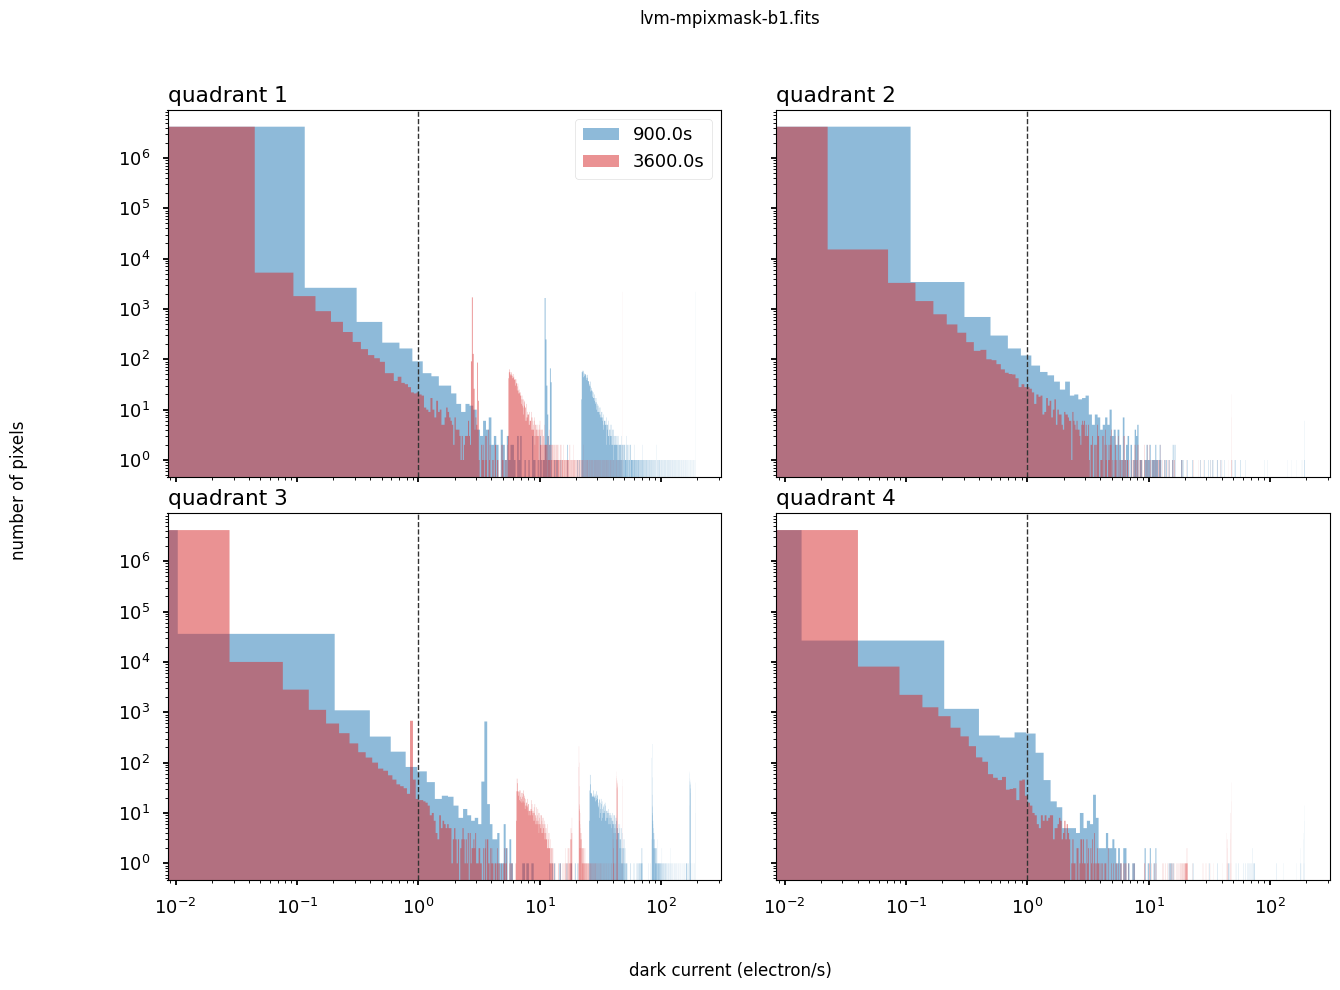

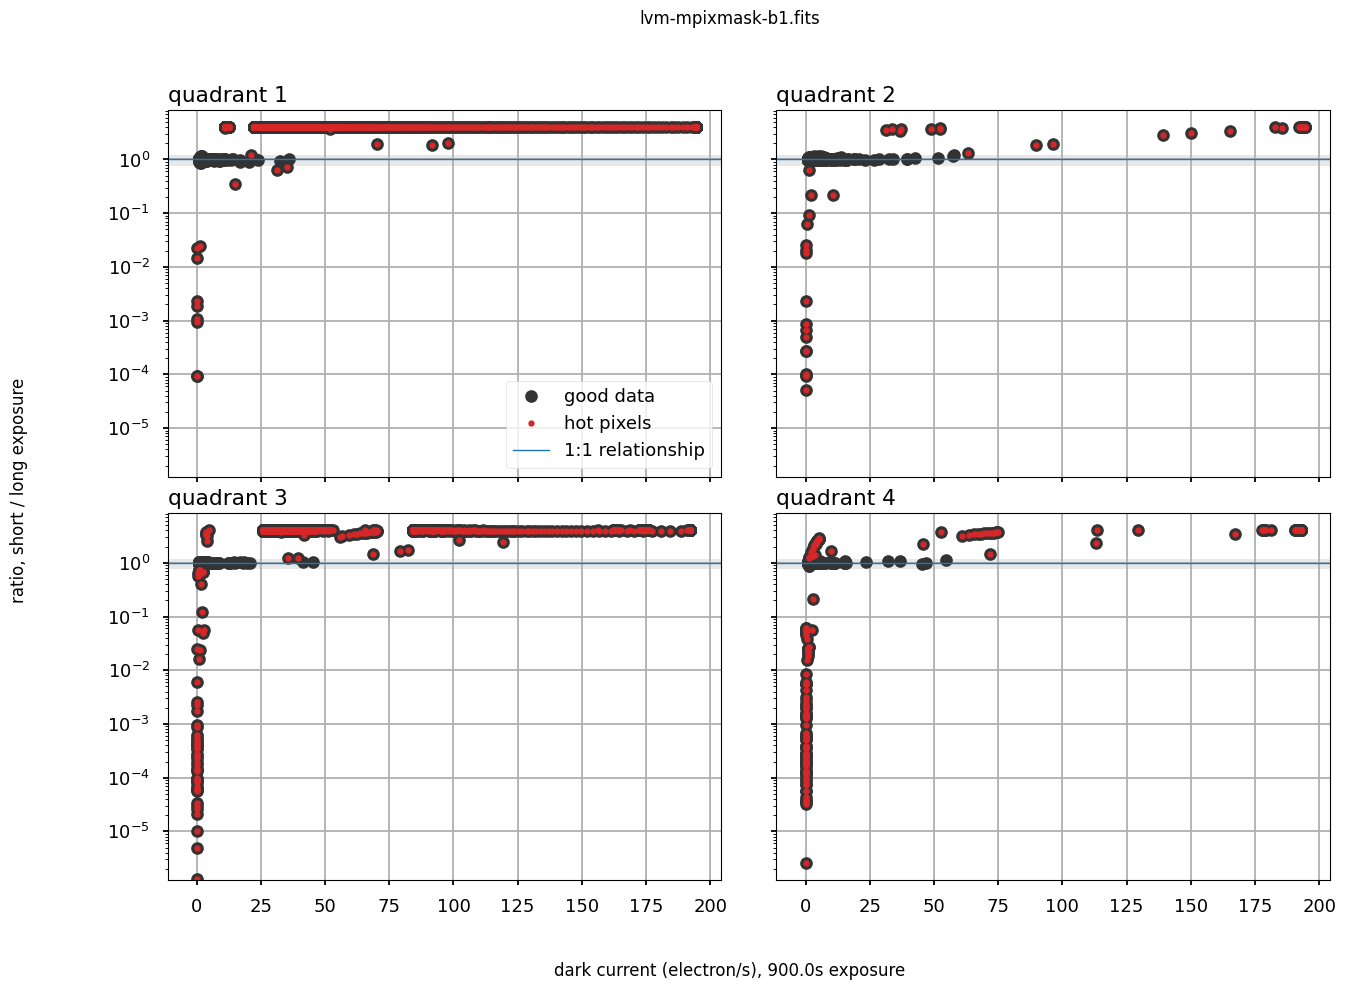

[INFO]: normalizing flats background with median_box = 20
[INFO]: normalizing flats by median: med_a = 1.00, med_b = 1.00
[INFO]: calculating ratio of flats: ratio_med = 1.00 [ratio_min = -6360.31, ratio_max = 7673.03
[INFO]: plotting flats histograms


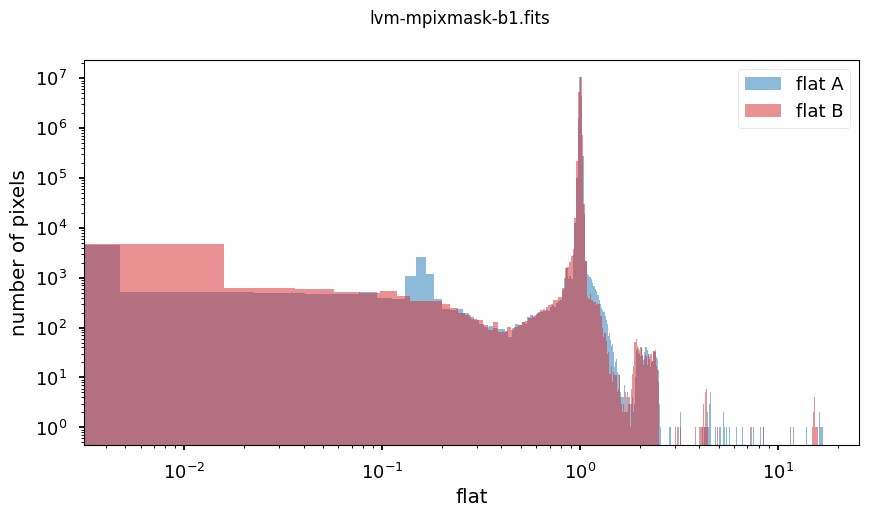

[INFO]: masking 56118 pixels in total (0.34%)
[INFO]: writing pixel mask to 'lvm-mpixmask-b1.fits'
[INFO]: loading short dark 'lvm-mdark-b2-900s.fits'
[INFO]: loading long dark 'lvm-mdark-b2-3600s.fits'
[INFO]: loading flat A 'lvm-dpixflat-b2-00003117.fits'
[INFO]: loading flat B 'lvm-dpixflat-b2-00003101.fits'
[INFO]: short exposure time = 900.0s
[INFO]: long exposure time = 3600.0s
[INFO]: creating pixel mask using dark current threshold = 1.0 electron/s
[INFO]: processing quadrant = [1:2043, 1:2040]
[INFO]: selecting 7042 pixels with dark current > 1.0 electron/s
[INFO]: masking 6653 pixels with ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [2044:4086, 1:2040]
[INFO]: selecting 816 pixels with dark current > 1.0 electron/s
[INFO]: masking 18 pixels with ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / 

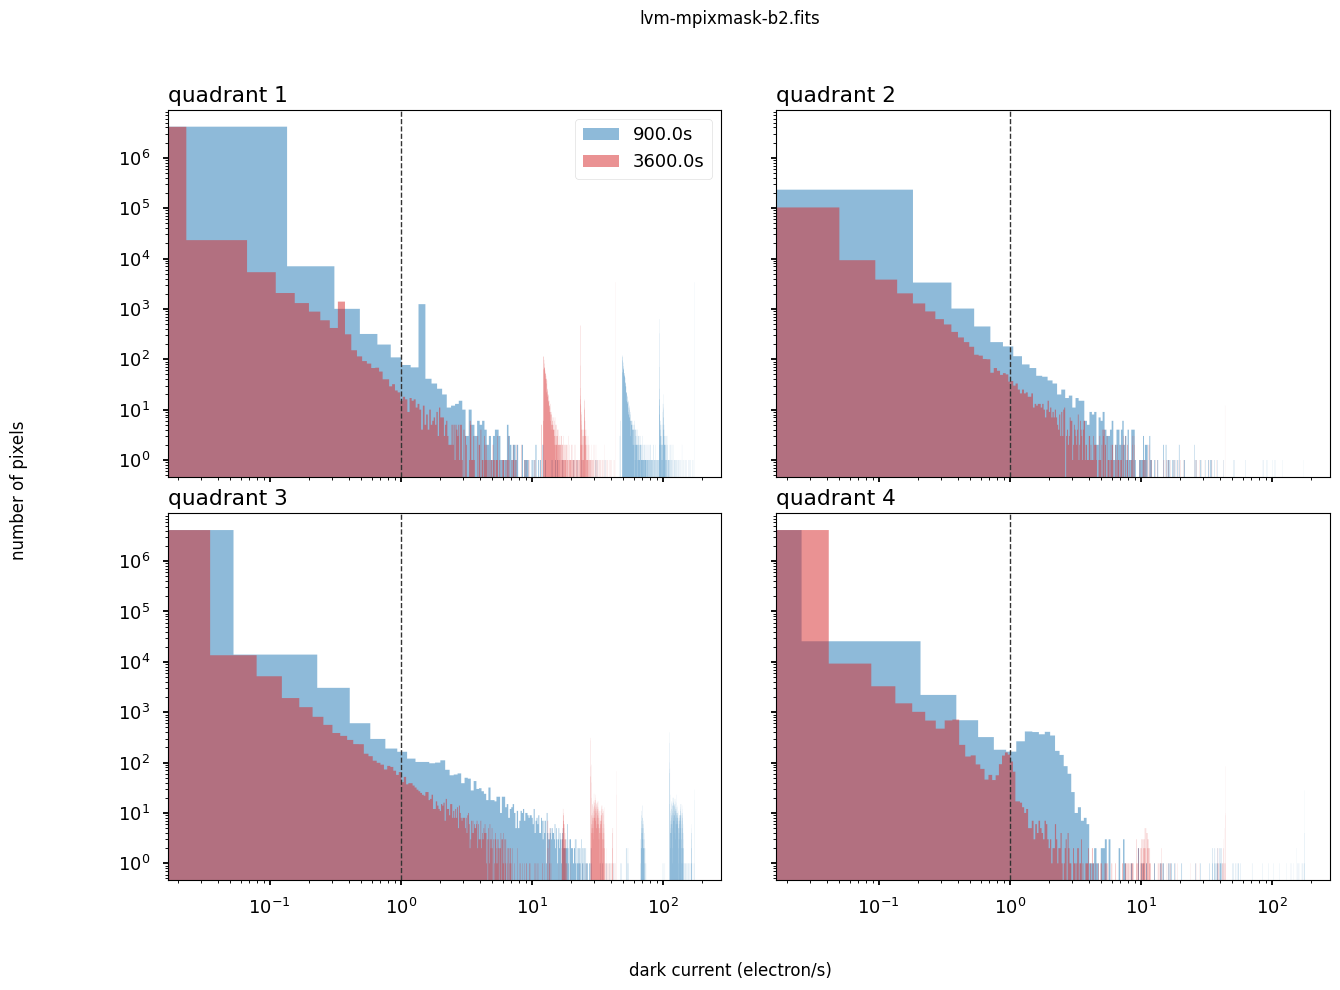

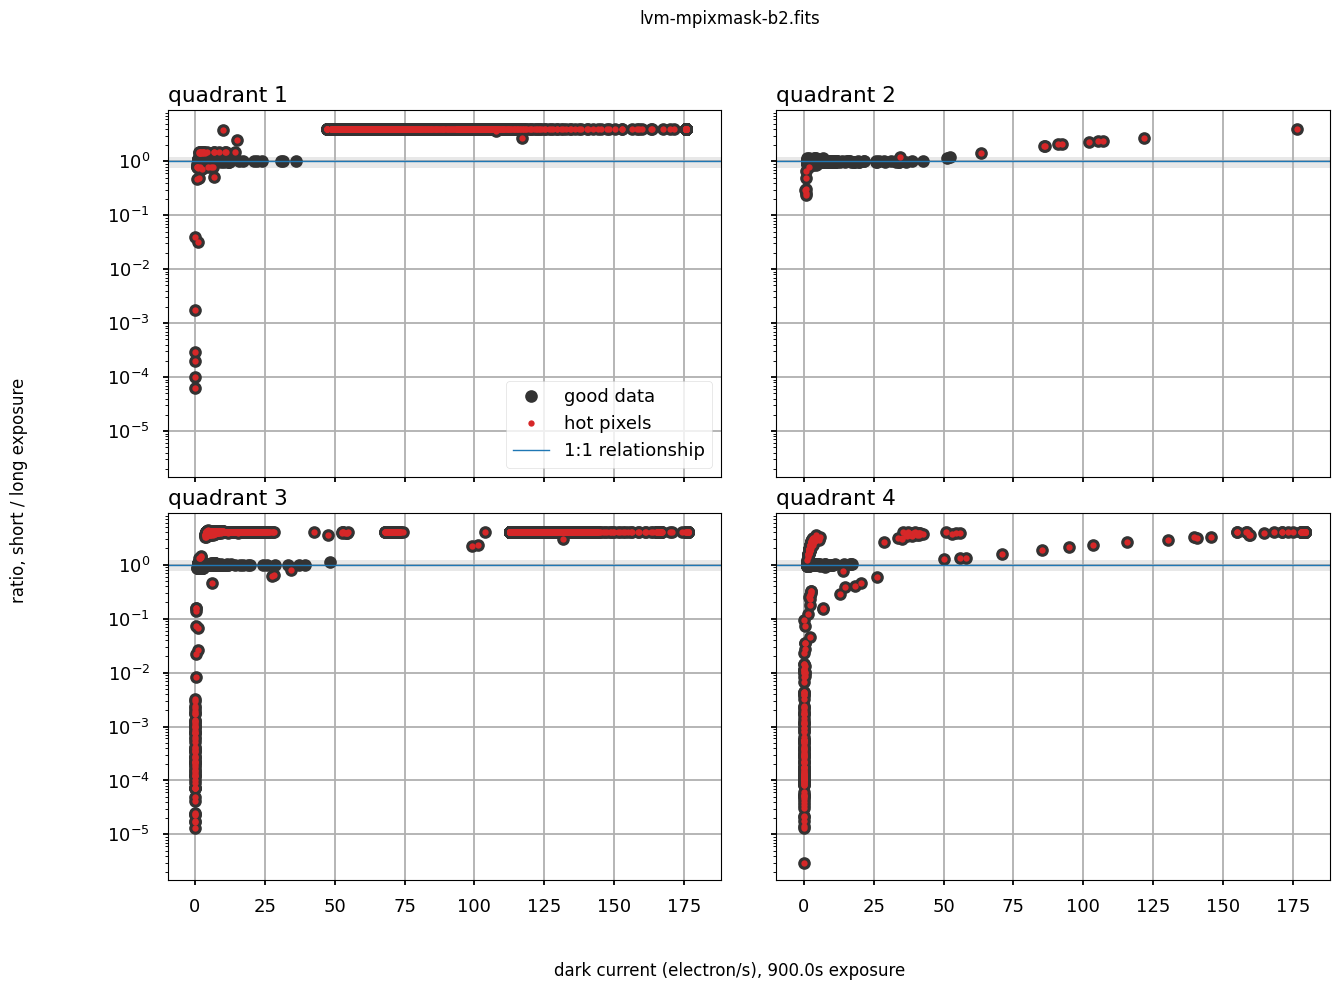

[INFO]: normalizing flats background with median_box = 20
[INFO]: normalizing flats by median: med_a = 1.00, med_b = 1.00
[INFO]: calculating ratio of flats: ratio_med = 1.00 [ratio_min = -4059.29, ratio_max = 30882.17
[INFO]: plotting flats histograms


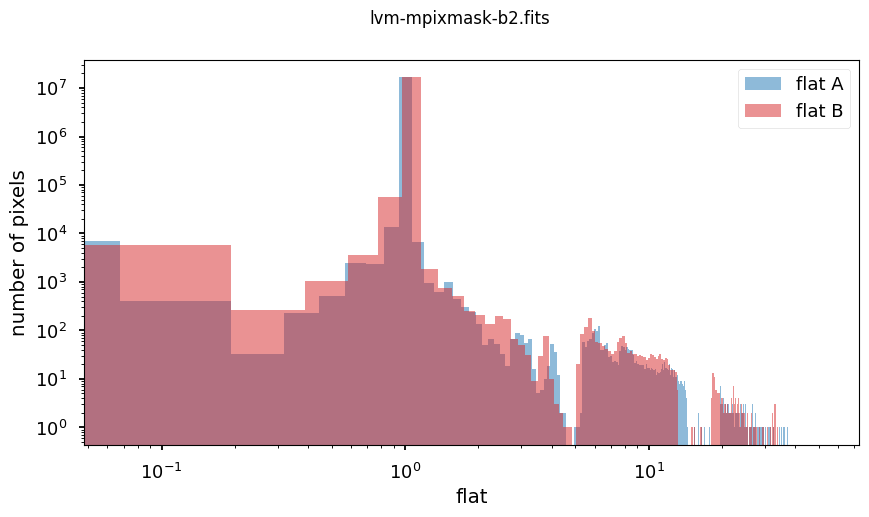

[INFO]: masking 76937 pixels in total (0.46%)
[INFO]: writing pixel mask to 'lvm-mpixmask-b2.fits'
[INFO]: loading short dark 'lvm-mdark-b3-900s.fits'
[INFO]: loading long dark 'lvm-mdark-b3-3600s.fits'
[INFO]: loading flat A 'lvm-dpixflat-b3-00003115.fits'
[INFO]: loading flat B 'lvm-dpixflat-b3-00003099.fits'
[INFO]: short exposure time = 900.0s
[INFO]: long exposure time = 3600.0s
[INFO]: creating pixel mask using dark current threshold = 1.0 electron/s
[INFO]: processing quadrant = [1:2043, 1:2040]
[INFO]: selecting 340 pixels with dark current > 1.0 electron/s
[INFO]: masking 2 pixels with ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [2044:4086, 1:2040]
[INFO]: selecting 385 pixels with dark current > 1.0 electron/s
[INFO]: masking 5 pixels with ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long 

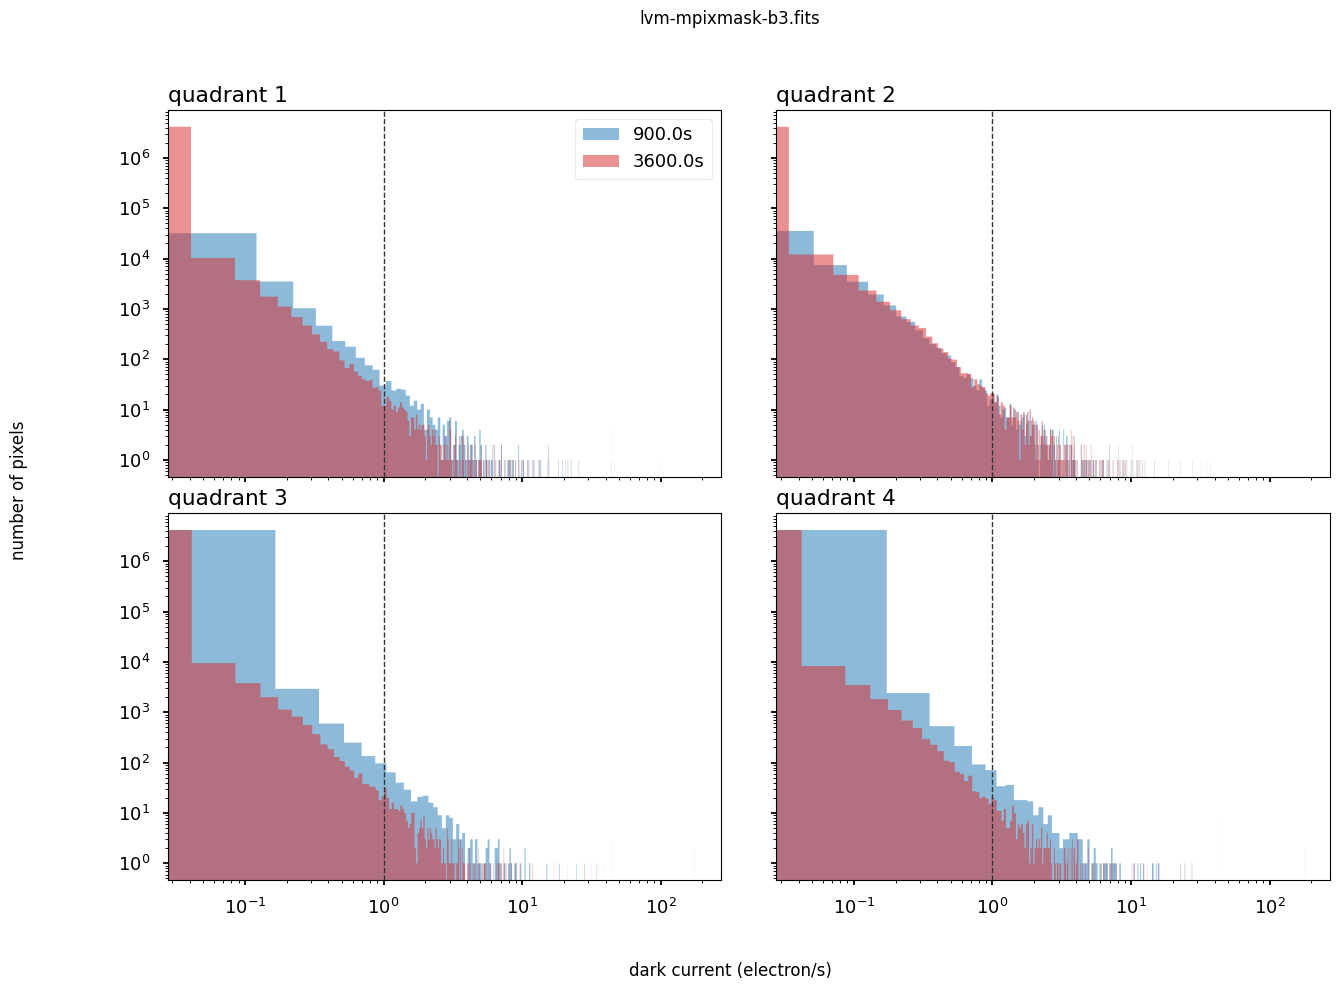

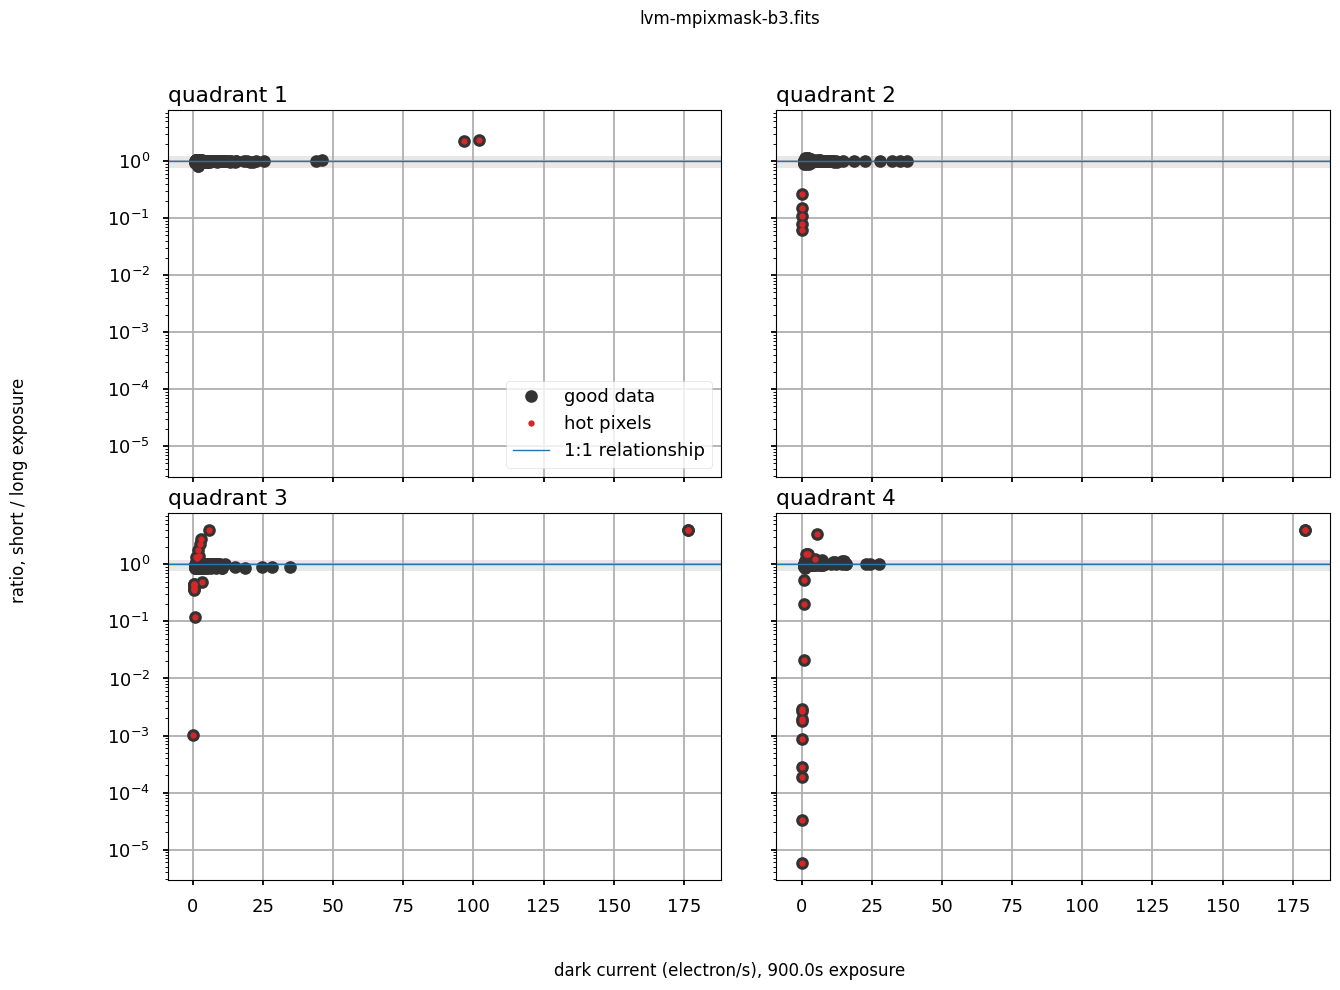

[INFO]: normalizing flats background with median_box = 20
[INFO]: normalizing flats by median: med_a = 1.00, med_b = 1.00
[INFO]: calculating ratio of flats: ratio_med = 1.00 [ratio_min = -8187.42, ratio_max = 3147.38
[INFO]: plotting flats histograms


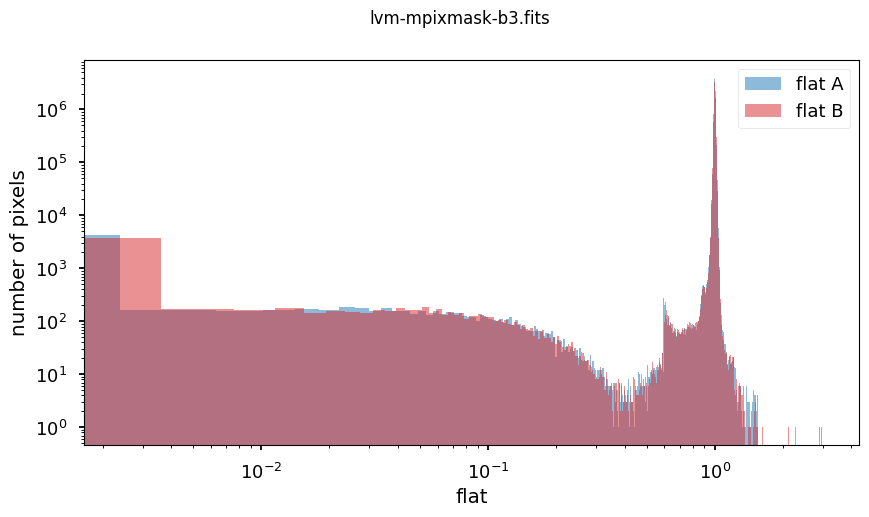

[INFO]: masking 25865 pixels in total (0.16%)
[INFO]: writing pixel mask to 'lvm-mpixmask-b3.fits'
[INFO]: loading short dark 'lvm-mdark-r1-900s.fits'
[INFO]: loading long dark 'lvm-mdark-r1-3600s.fits'
[INFO]: loading flat A 'lvm-dpixflat-r1-00003116.fits'
[INFO]: loading flat B 'lvm-dpixflat-r1-00003113.fits'
[INFO]: short exposure time = 900.0s
[INFO]: long exposure time = 3600.0s
[INFO]: creating pixel mask using dark current threshold = 1.0 electron/s
[INFO]: processing quadrant = [1:2043, 1:2040]
[INFO]: selecting 588 pixels with dark current > 1.0 electron/s
[INFO]: masking 372 pixels with ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [2044:4086, 1:2040]
[INFO]: selecting 457 pixels with dark current > 1.0 electron/s
[INFO]: masking 176 pixels with ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / l

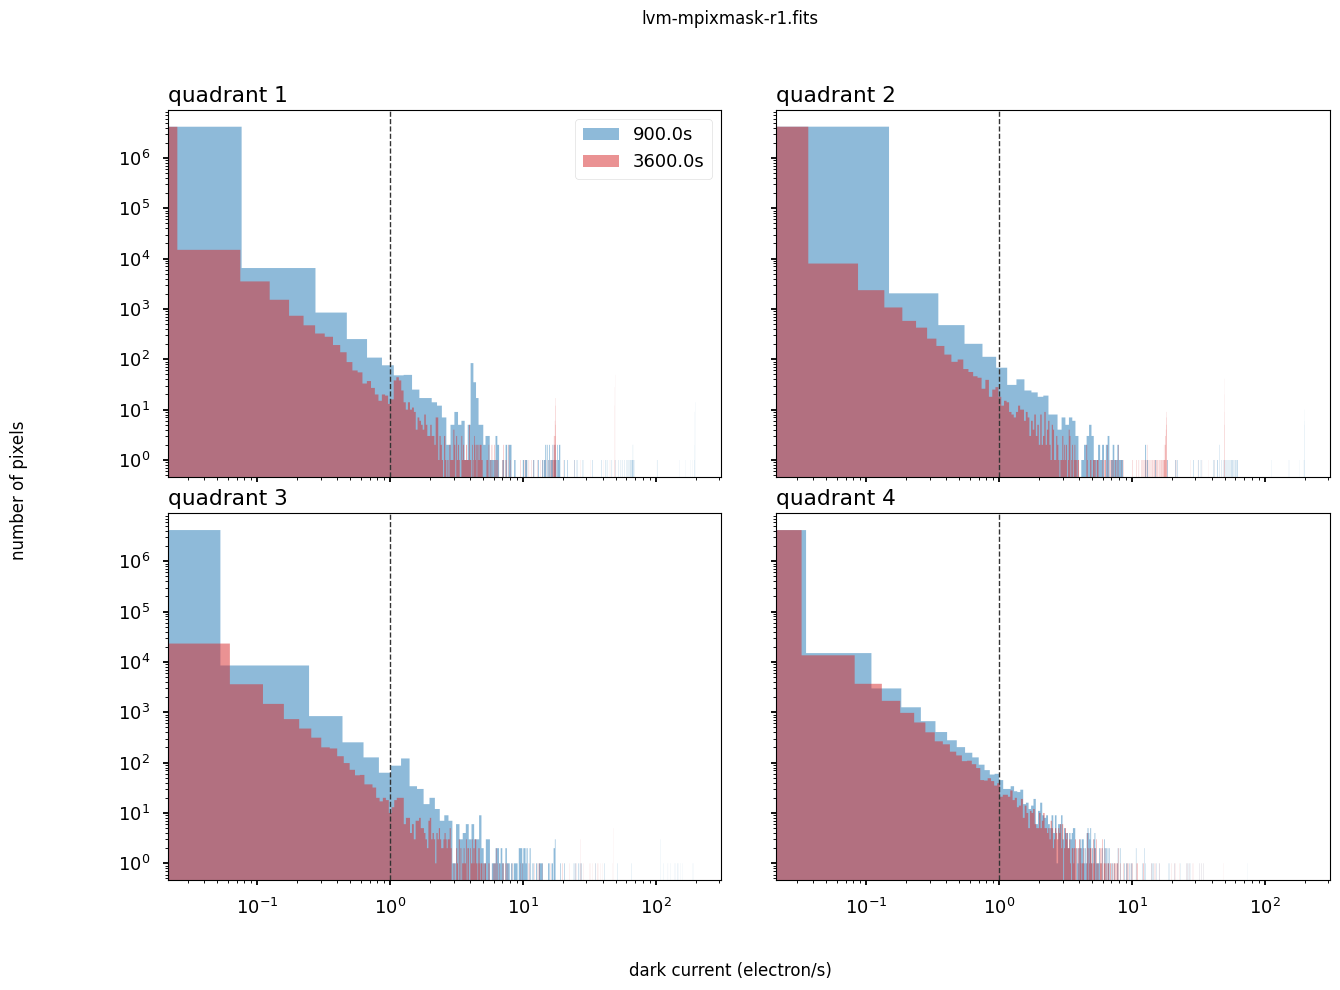

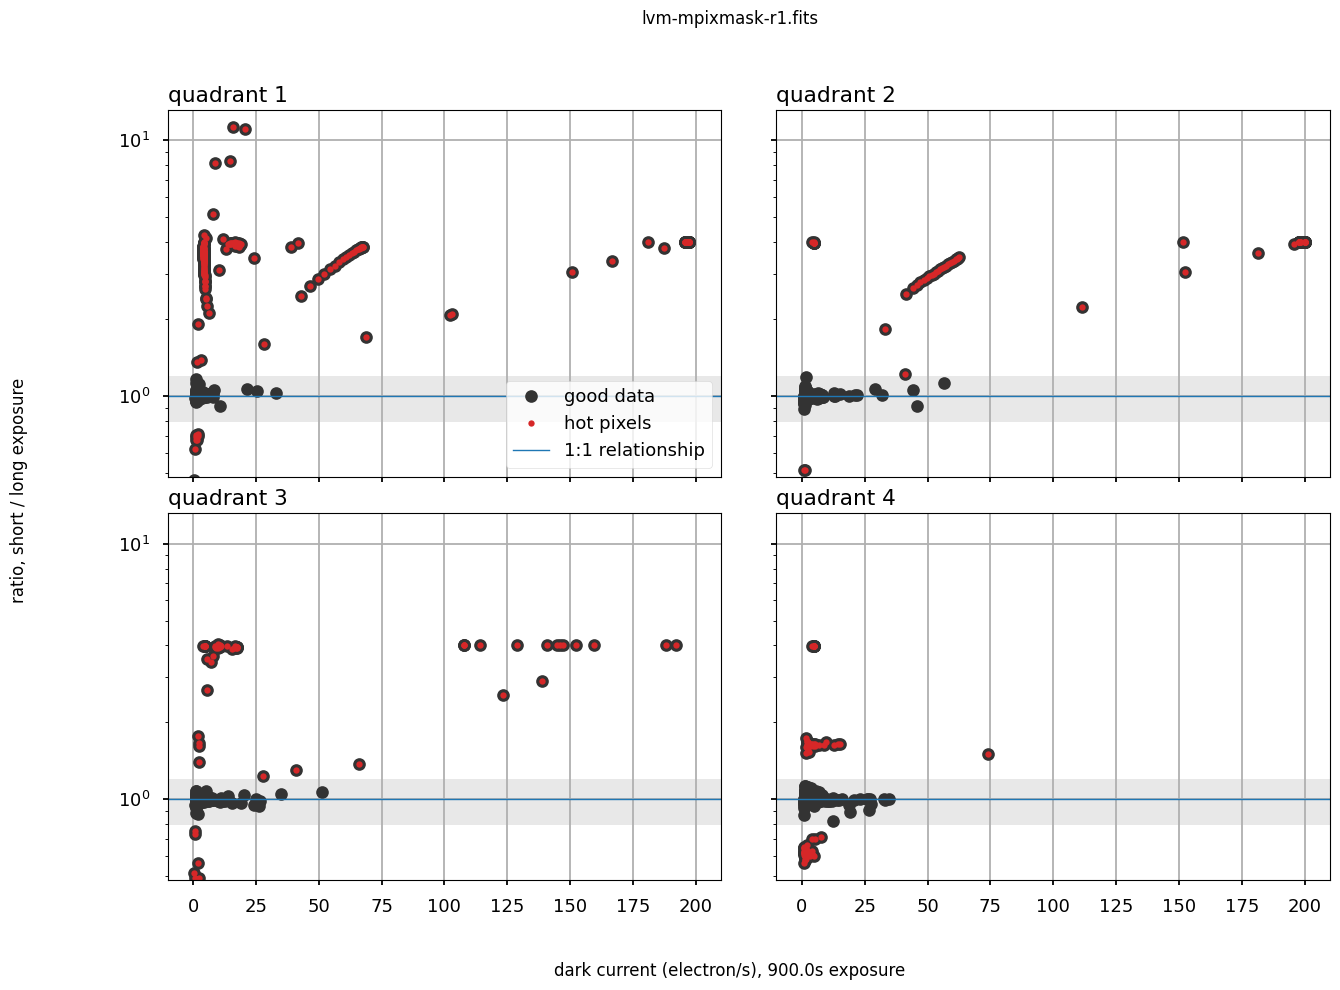

[INFO]: normalizing flats background with median_box = 20
[INFO]: normalizing flats by median: med_a = 1.00, med_b = 1.00
[INFO]: calculating ratio of flats: ratio_med = 1.00 [ratio_min = -657.53, ratio_max = 5283.53
[INFO]: plotting flats histograms


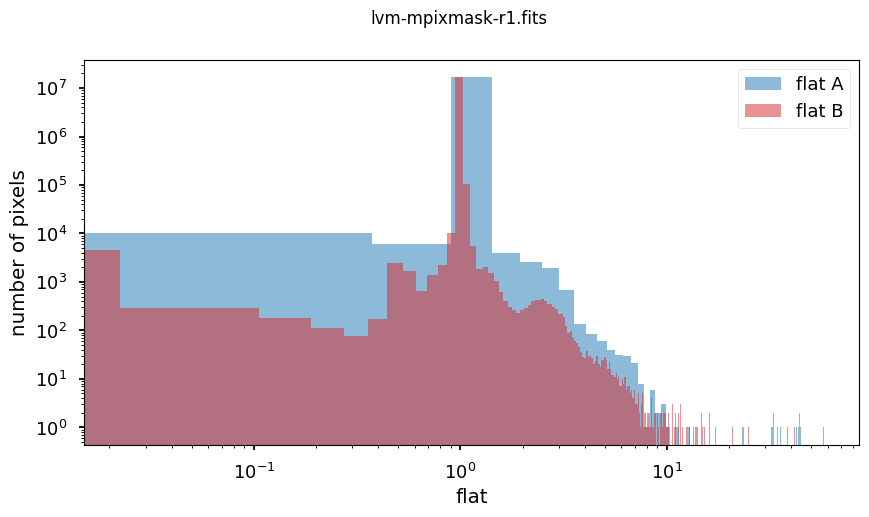

[INFO]: masking 91749 pixels in total (0.55%)
[INFO]: writing pixel mask to 'lvm-mpixmask-r1.fits'
[INFO]: loading short dark 'lvm-mdark-r2-900s.fits'
[INFO]: loading long dark 'lvm-mdark-r2-3600s.fits'
[INFO]: loading flat A 'lvm-dpixflat-r2-00003117.fits'
[INFO]: loading flat B 'lvm-dpixflat-r2-00003101.fits'
[INFO]: short exposure time = 900.0s
[INFO]: long exposure time = 3600.0s
[INFO]: creating pixel mask using dark current threshold = 1.0 electron/s
[INFO]: processing quadrant = [1:2043, 1:2040]
[INFO]: selecting 287 pixels with dark current > 1.0 electron/s
[INFO]: masking 31 pixels with ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [2044:4086, 1:2040]
[INFO]: selecting 3221 pixels with dark current > 1.0 electron/s
[INFO]: masking 2835 pixels with ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / 

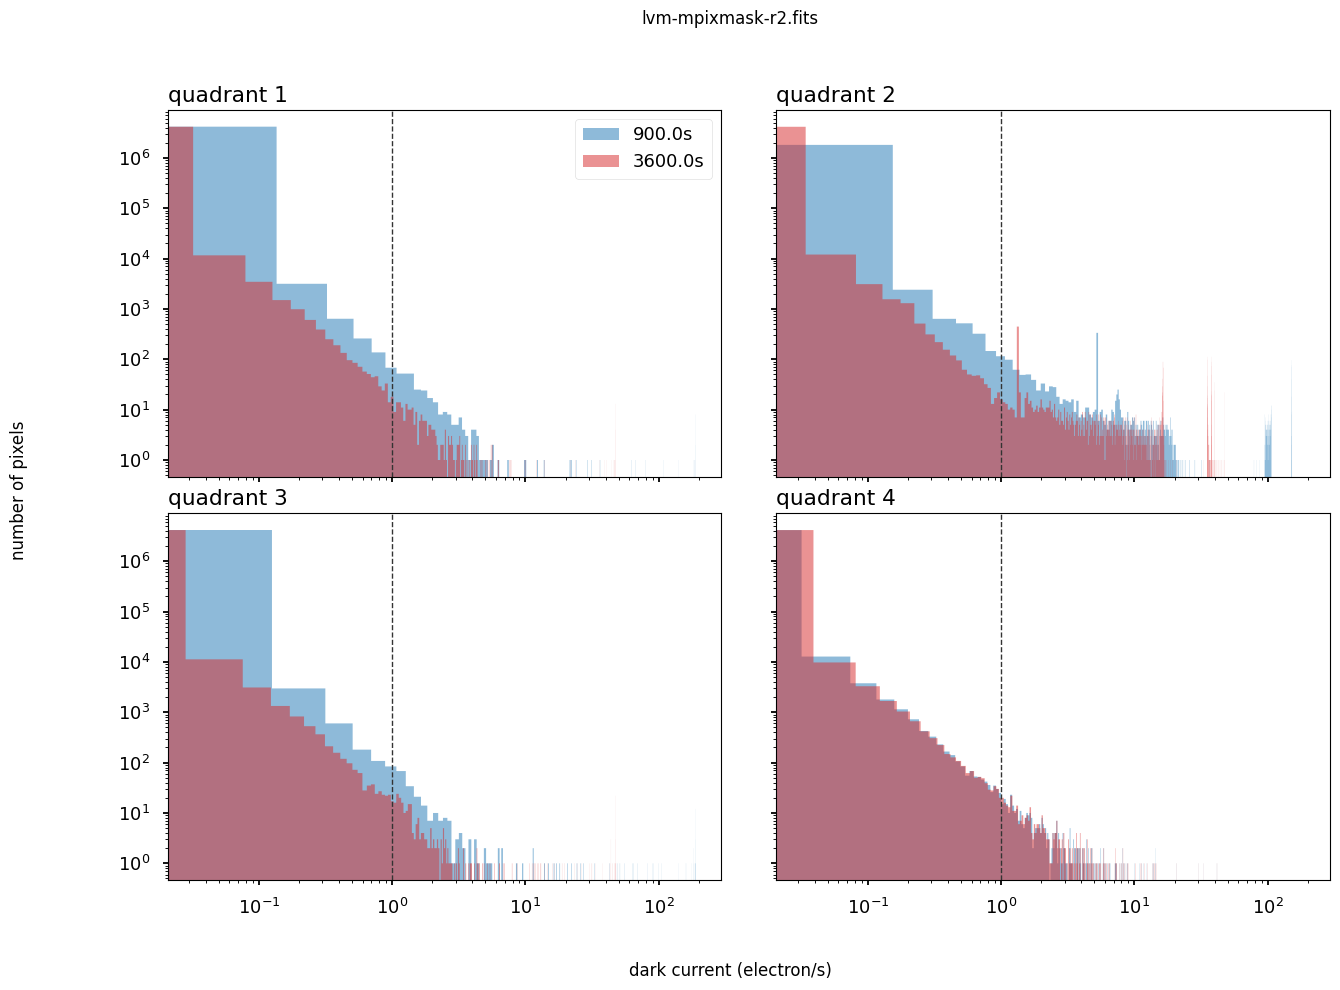

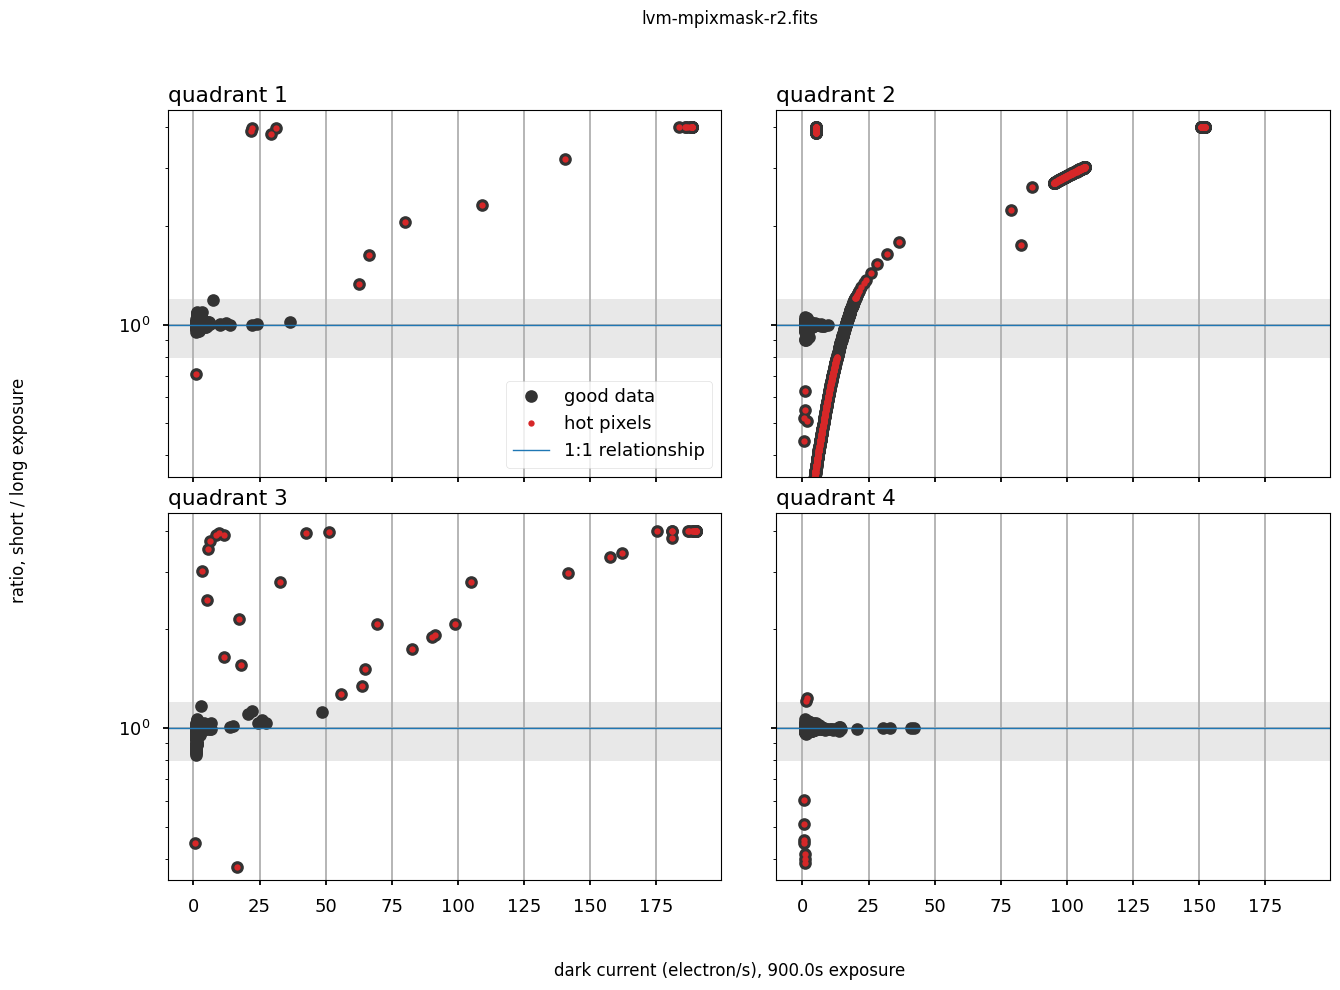

[INFO]: normalizing flats background with median_box = 20
[INFO]: normalizing flats by median: med_a = 1.00, med_b = 1.00
[INFO]: calculating ratio of flats: ratio_med = 1.00 [ratio_min = -25327.25, ratio_max = 9056.39
[INFO]: plotting flats histograms


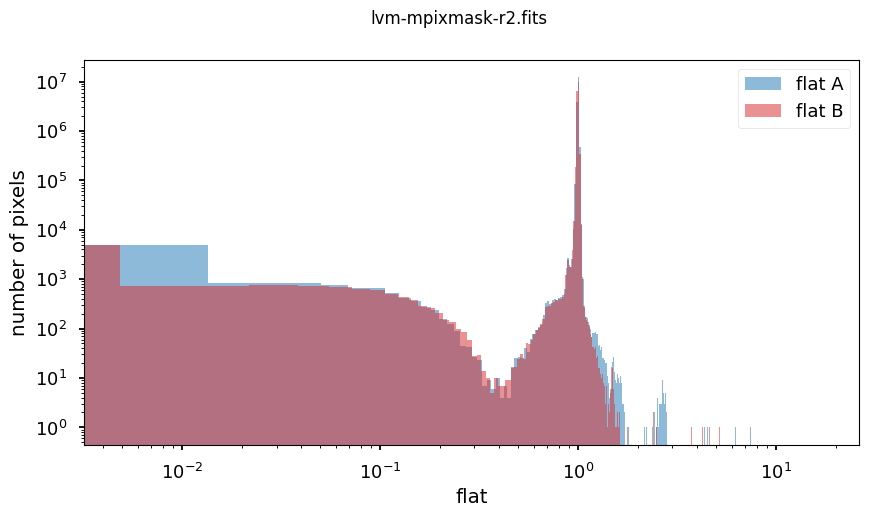

[INFO]: masking 42541 pixels in total (0.26%)
[INFO]: writing pixel mask to 'lvm-mpixmask-r2.fits'
[INFO]: loading short dark 'lvm-mdark-r3-900s.fits'
[INFO]: loading long dark 'lvm-mdark-r3-3600s.fits'
[INFO]: loading flat A 'lvm-dpixflat-r3-00003115.fits'
[INFO]: loading flat B 'lvm-dpixflat-r3-00003099.fits'
[INFO]: short exposure time = 900.0s
[INFO]: long exposure time = 3600.0s
[INFO]: creating pixel mask using dark current threshold = 1.0 electron/s
[INFO]: processing quadrant = [1:2043, 1:2040]
[INFO]: selecting 3609 pixels with dark current > 1.0 electron/s
[INFO]: masking 3113 pixels with ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [2044:4086, 1:2040]
[INFO]: selecting 630 pixels with dark current > 1.0 electron/s
[INFO]: masking 62 pixels with ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / 

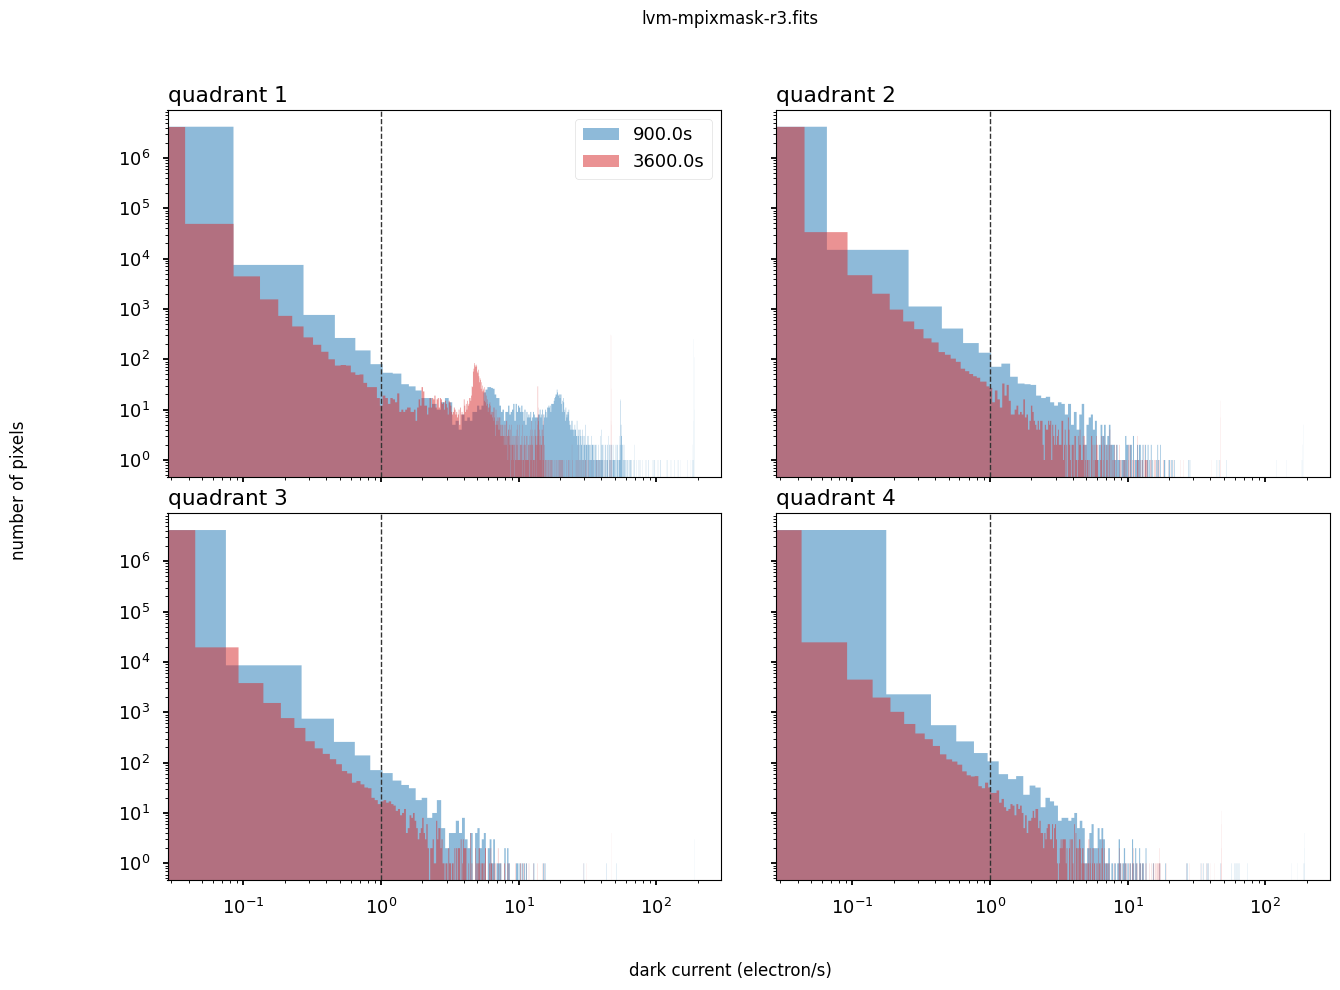

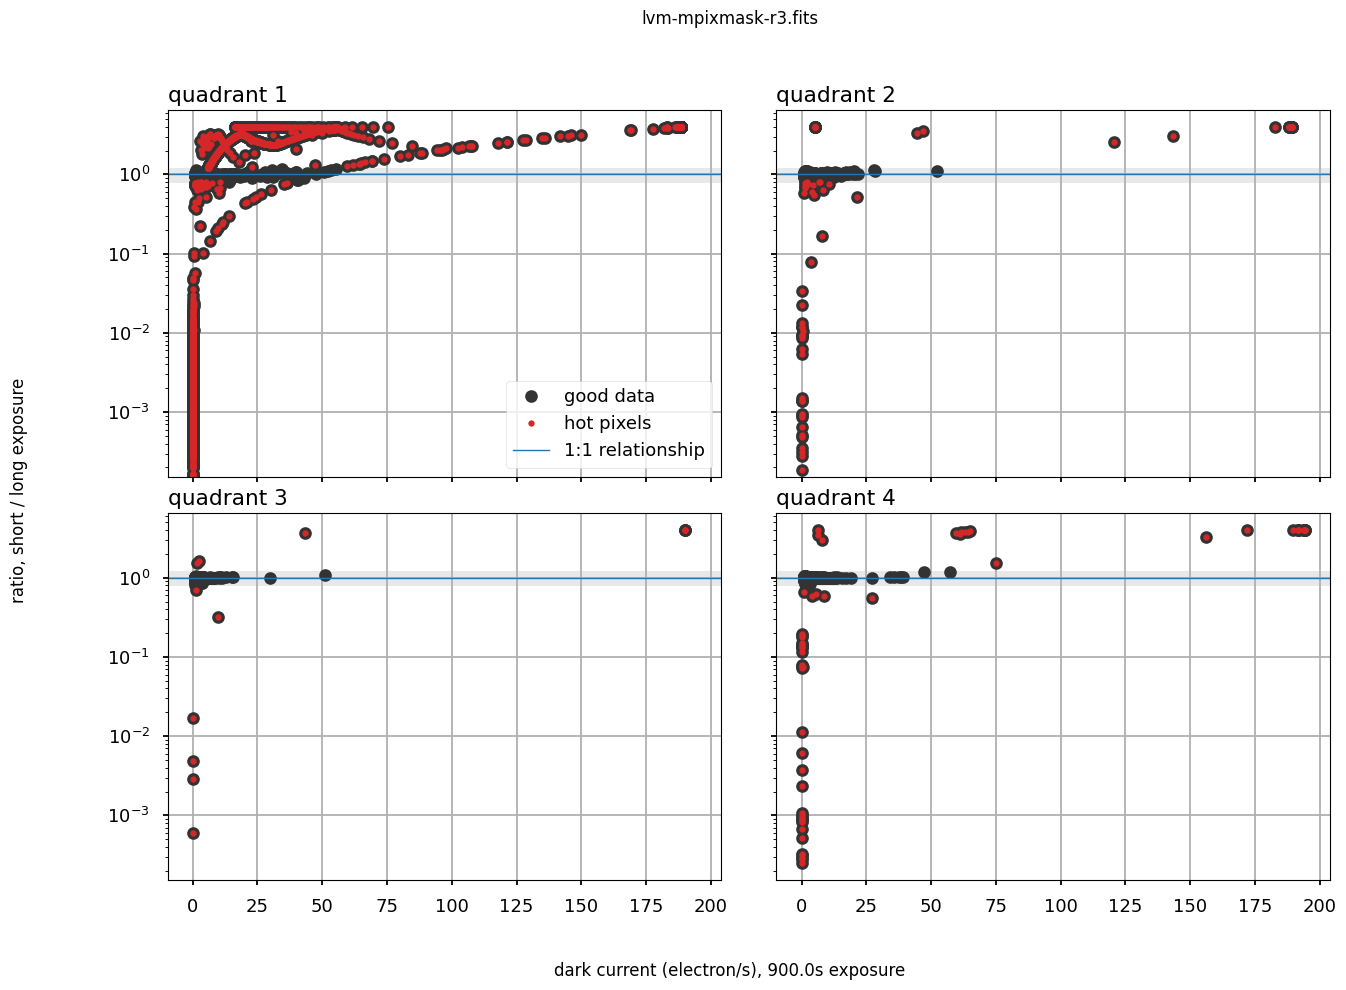

[INFO]: normalizing flats background with median_box = 20
[INFO]: normalizing flats by median: med_a = 1.00, med_b = 1.00
[INFO]: calculating ratio of flats: ratio_med = 1.00 [ratio_min = -10370.46, ratio_max = 152509.67
[INFO]: plotting flats histograms


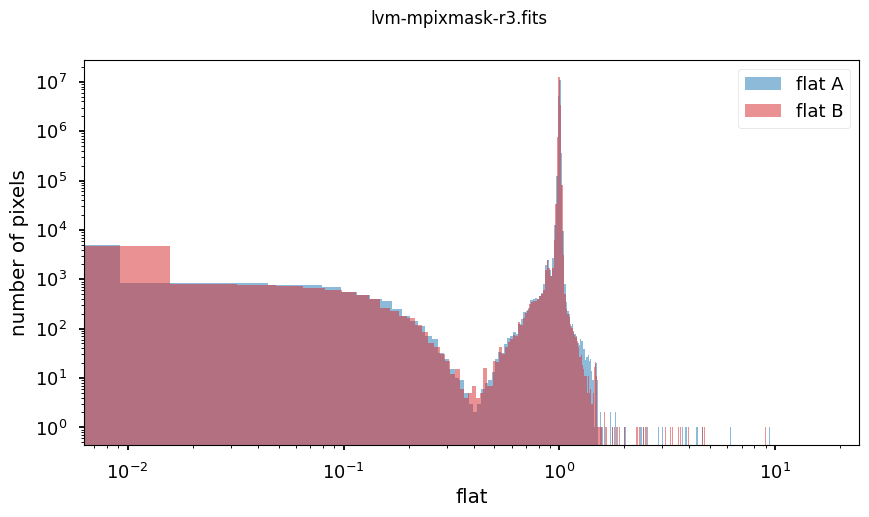

[INFO]: masking 44582 pixels in total (0.27%)
[INFO]: writing pixel mask to 'lvm-mpixmask-r3.fits'
[INFO]: loading short dark 'lvm-mdark-z1-900s.fits'
[INFO]: loading long dark 'lvm-mdark-z1-3600s.fits'
[INFO]: loading flat A 'lvm-dpixflat-z1-00003116.fits'
[INFO]: loading flat B 'lvm-dpixflat-z1-00003099.fits'
[INFO]: short exposure time = 900.0s
[INFO]: long exposure time = 3600.0s
[INFO]: creating pixel mask using dark current threshold = 1.0 electron/s
[INFO]: processing quadrant = [1:2043, 1:2040]
[INFO]: selecting 5813 pixels with dark current > 1.0 electron/s
[INFO]: masking 931 pixels with ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [2044:4086, 1:2040]
[INFO]: selecting 227 pixels with dark current > 1.0 electron/s
[INFO]: masking 1 pixels with ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / lo

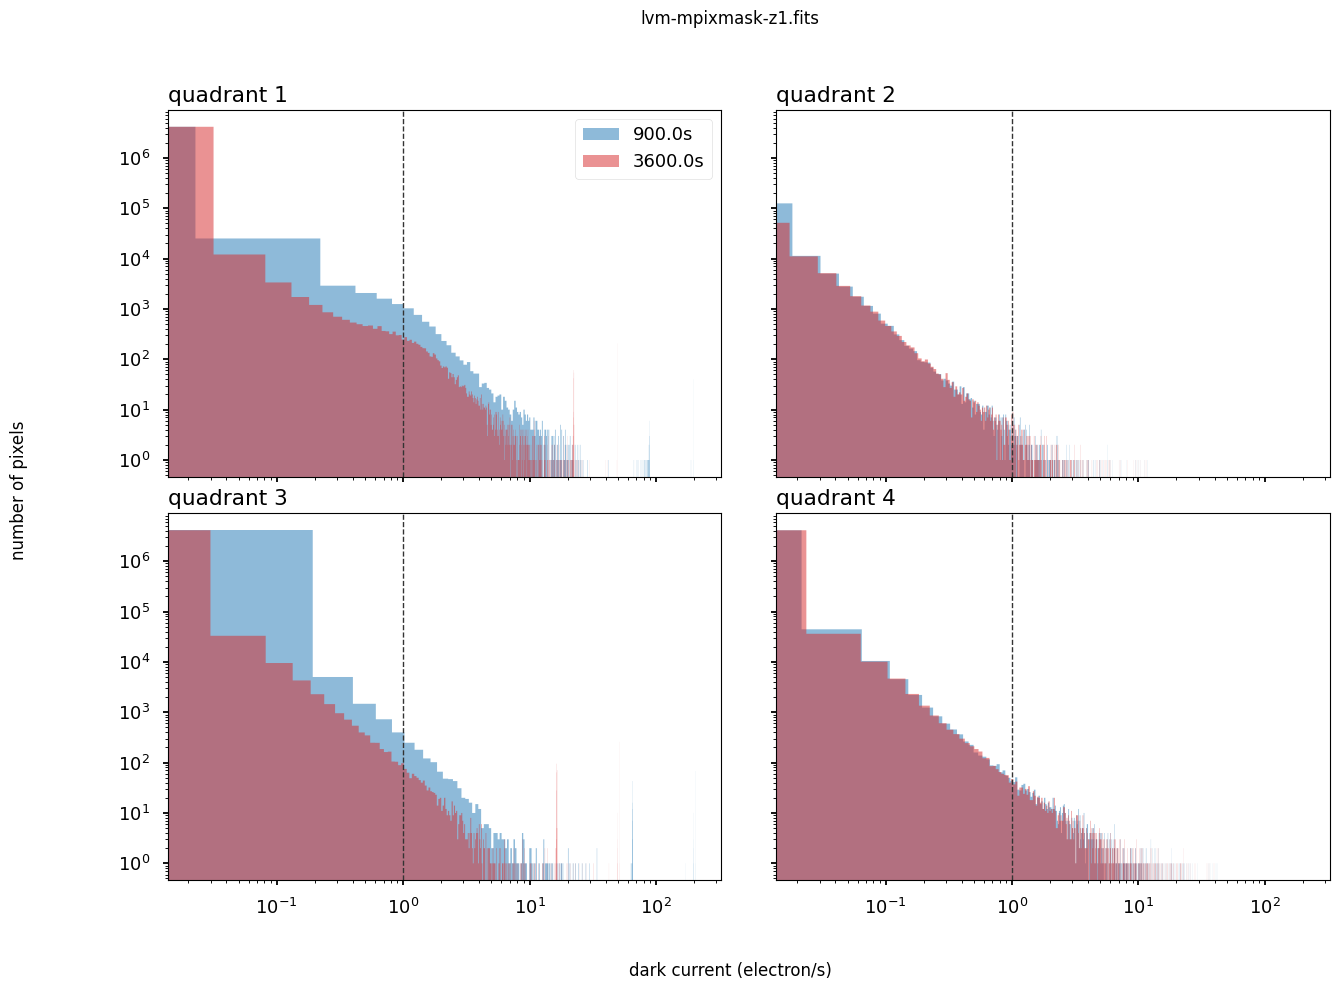

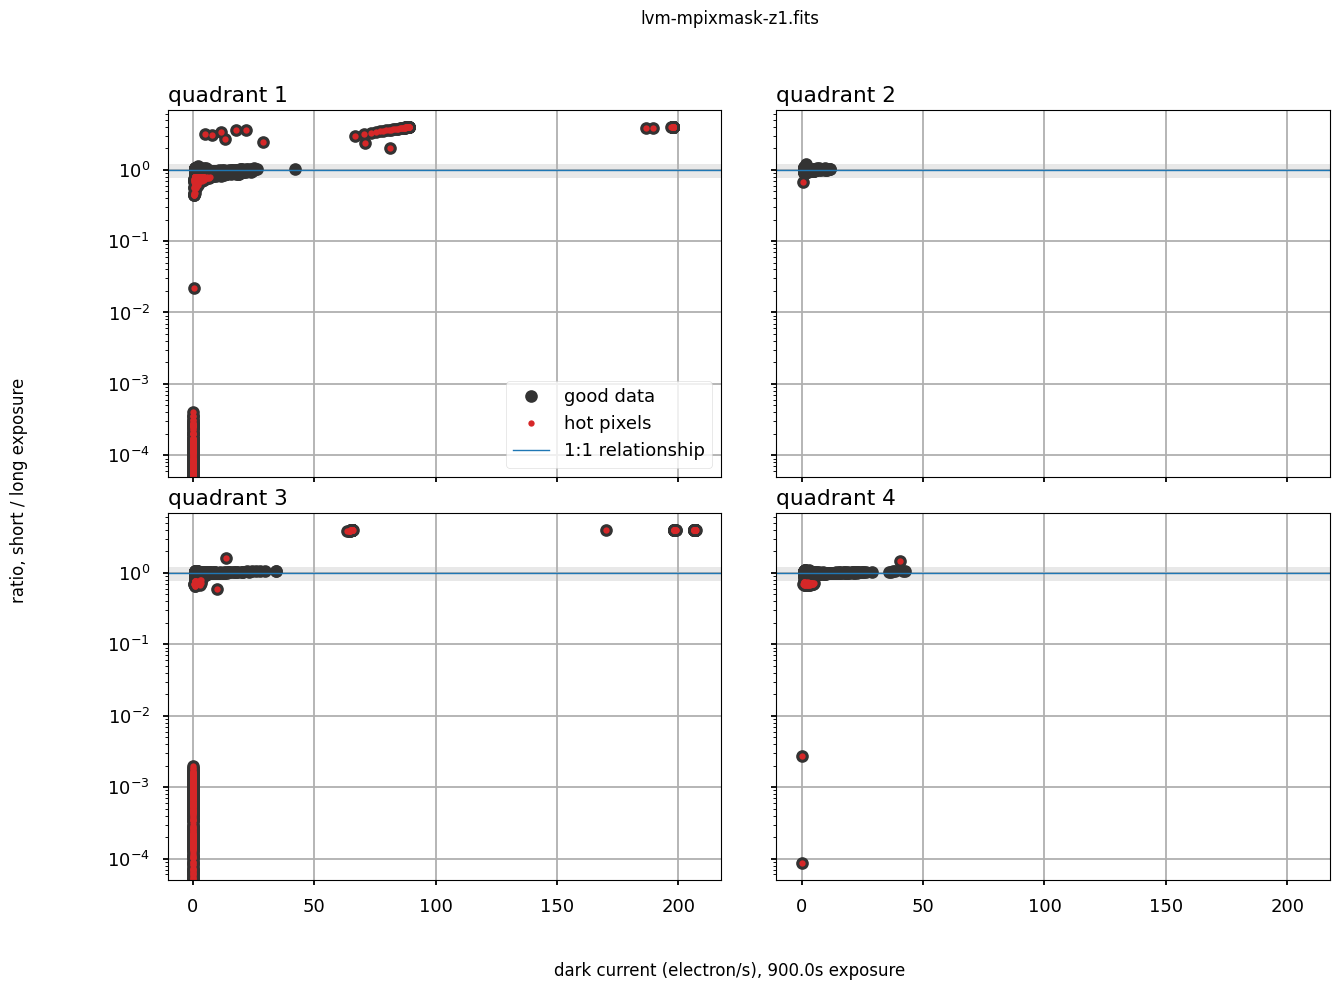

[INFO]: normalizing flats background with median_box = 20
[INFO]: normalizing flats by median: med_a = 1.00, med_b = 1.00
[INFO]: calculating ratio of flats: ratio_med = 1.00 [ratio_min = -12459.12, ratio_max = 15899.23
[INFO]: plotting flats histograms


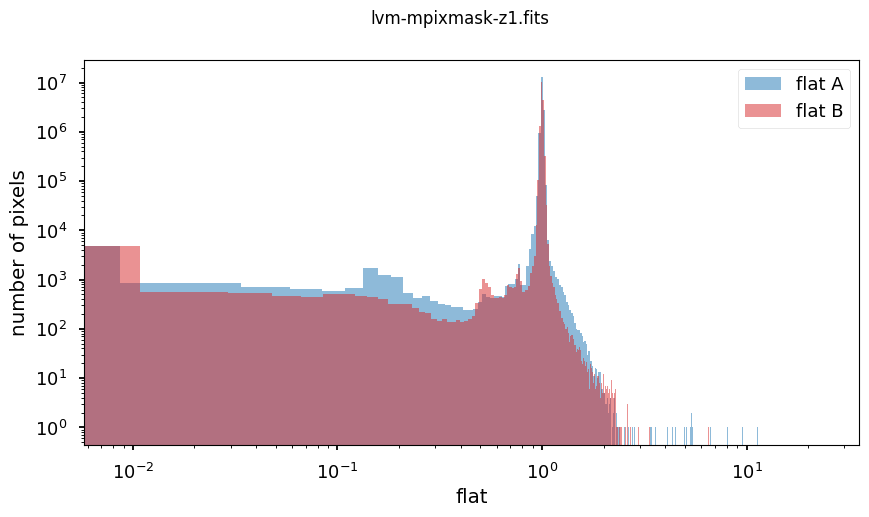

[INFO]: masking 39522 pixels in total (0.24%)
[INFO]: writing pixel mask to 'lvm-mpixmask-z1.fits'
[INFO]: loading short dark 'lvm-mdark-z2-900s.fits'
[INFO]: loading long dark 'lvm-mdark-z2-3600s.fits'
[INFO]: loading flat A 'lvm-dpixflat-z2-00003117.fits'
[INFO]: loading flat B 'lvm-dpixflat-z2-00003101.fits'
[INFO]: short exposure time = 900.0s
[INFO]: long exposure time = 3600.0s
[INFO]: creating pixel mask using dark current threshold = 1.0 electron/s
[INFO]: processing quadrant = [1:2043, 1:2040]
[INFO]: selecting 398 pixels with dark current > 1.0 electron/s
[INFO]: masking 44 pixels with ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [2044:4086, 1:2040]
[INFO]: selecting 4477 pixels with dark current > 1.0 electron/s
[INFO]: masking 4313 pixels with ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / 

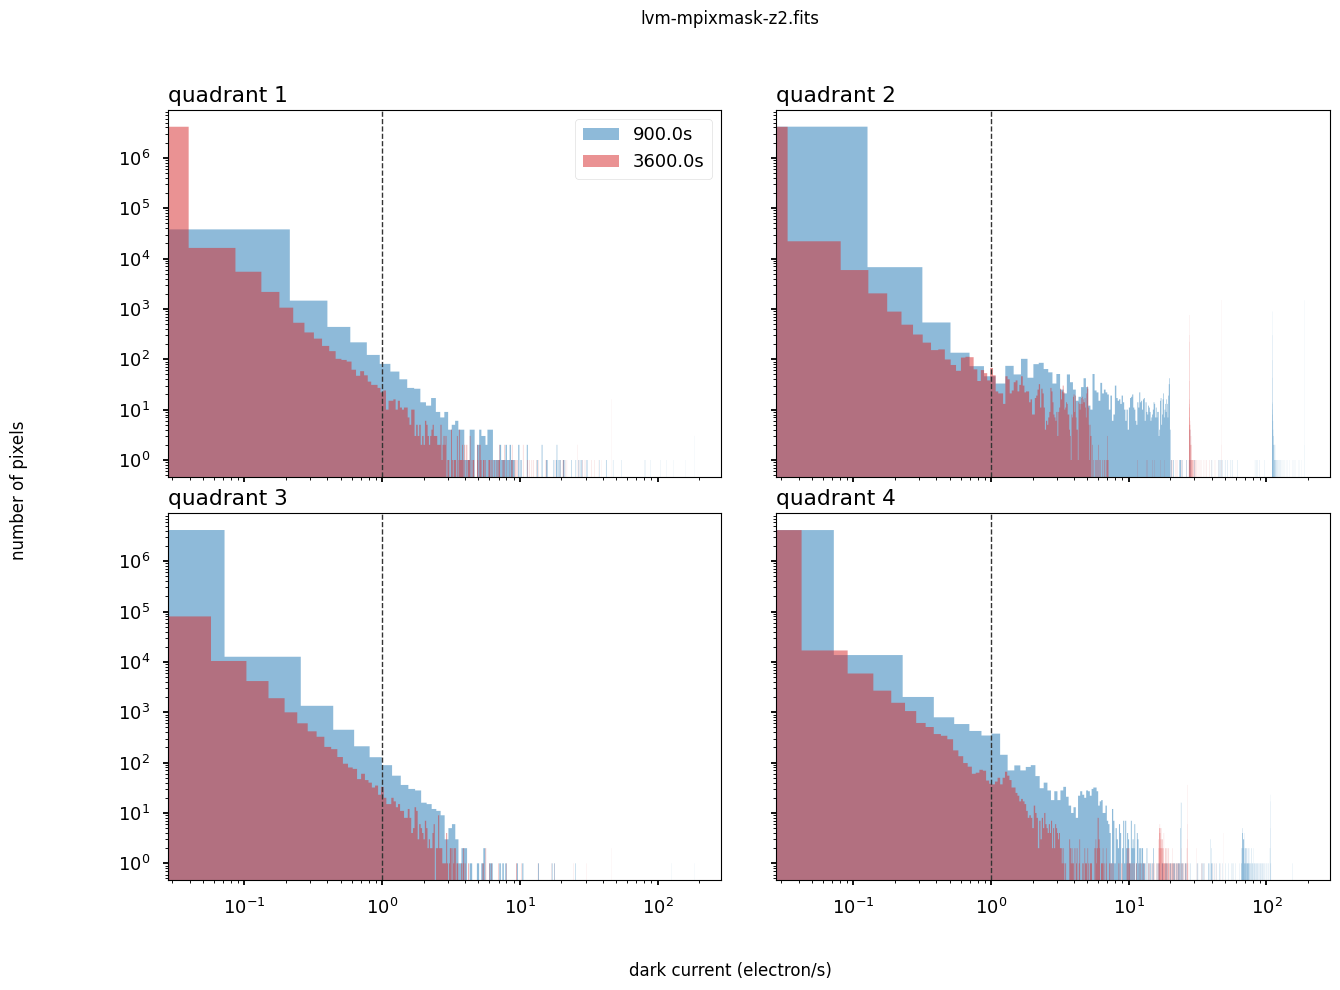

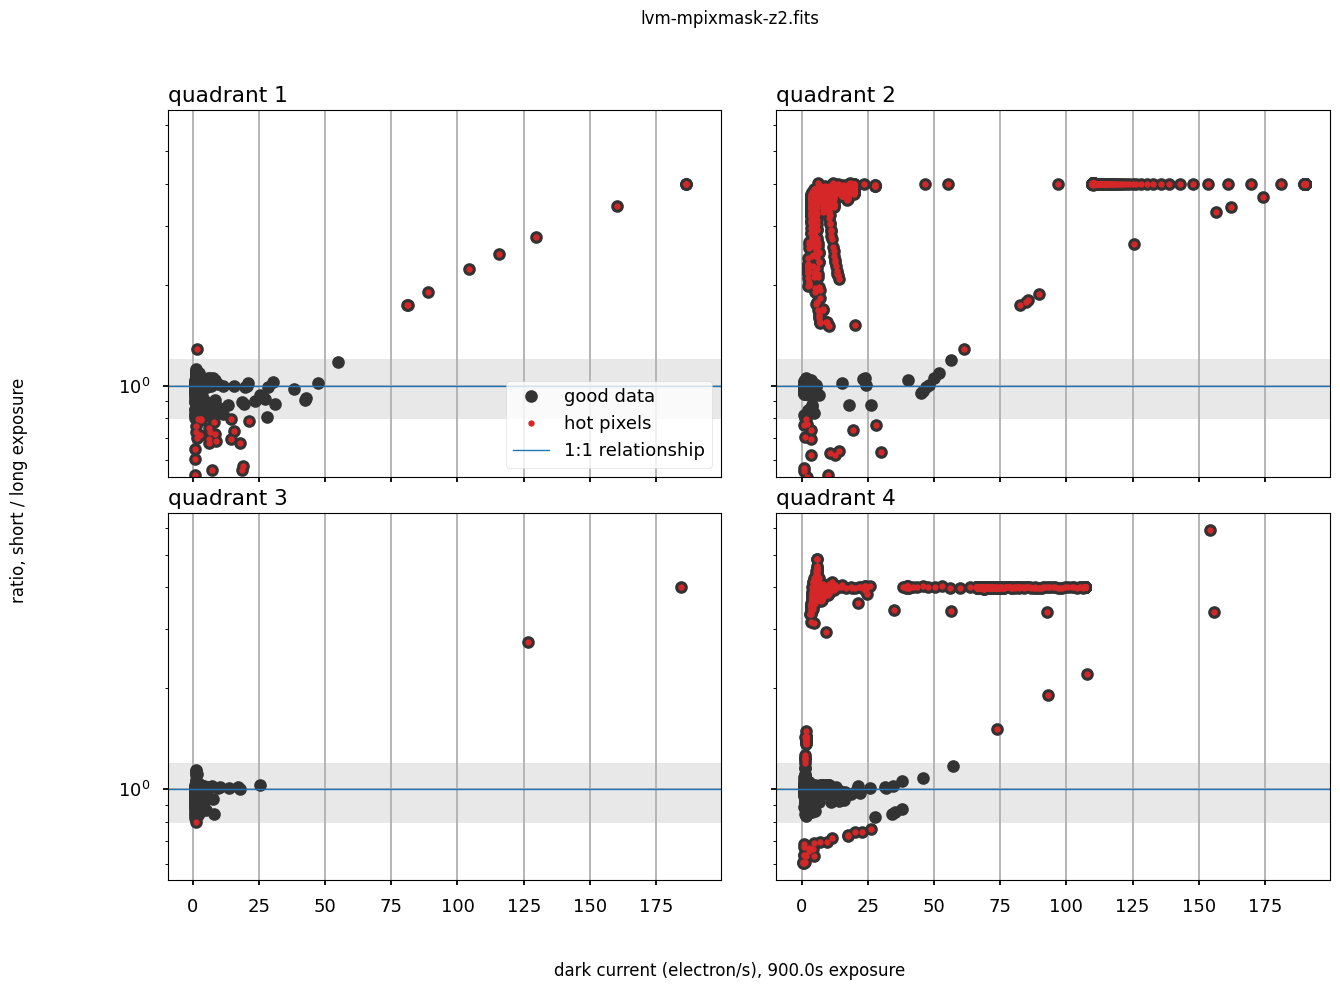

[INFO]: normalizing flats background with median_box = 20
[INFO]: normalizing flats by median: med_a = 1.00, med_b = 1.00
[INFO]: calculating ratio of flats: ratio_med = 1.00 [ratio_min = -15101.63, ratio_max = 5331.07
[INFO]: plotting flats histograms


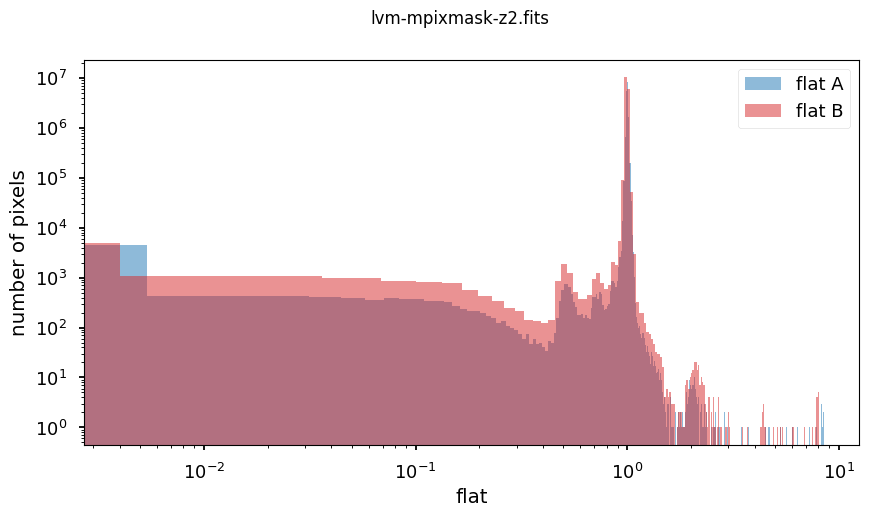

[INFO]: masking 58497 pixels in total (0.35%)
[INFO]: writing pixel mask to 'lvm-mpixmask-z2.fits'
[INFO]: loading short dark 'lvm-mdark-z3-900s.fits'
[INFO]: loading long dark 'lvm-mdark-z3-3600s.fits'
[INFO]: loading flat A 'lvm-dpixflat-z3-00003115.fits'
[INFO]: loading flat B 'lvm-dpixflat-z3-00003099.fits'
[INFO]: short exposure time = 900.0s
[INFO]: long exposure time = 3600.0s
[INFO]: creating pixel mask using dark current threshold = 1.0 electron/s
[INFO]: processing quadrant = [1:2043, 1:2040]
[INFO]: selecting 393 pixels with dark current > 1.0 electron/s
[INFO]: masking 51 pixels with ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / long exposures
[INFO]: processing quadrant = [2044:4086, 1:2040]
[INFO]: selecting 123 pixels with dark current > 1.0 electron/s
[INFO]: masking 11 pixels with ratio < 0.8 or > 1.2
[INFO]: plotting count distribution of short / long exposures
[INFO]: plotting ratio of short / lon

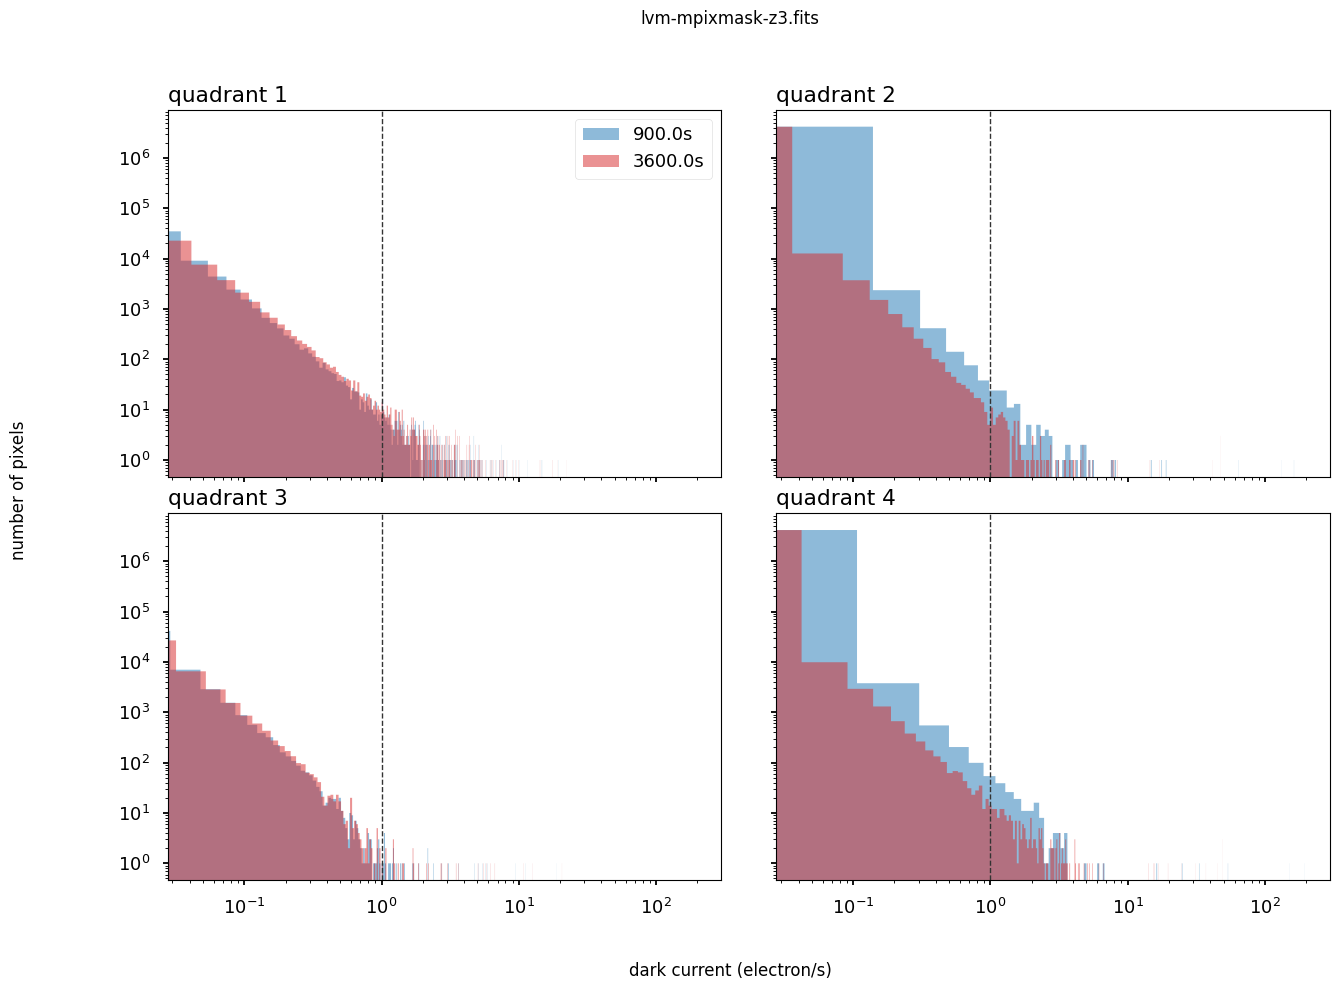

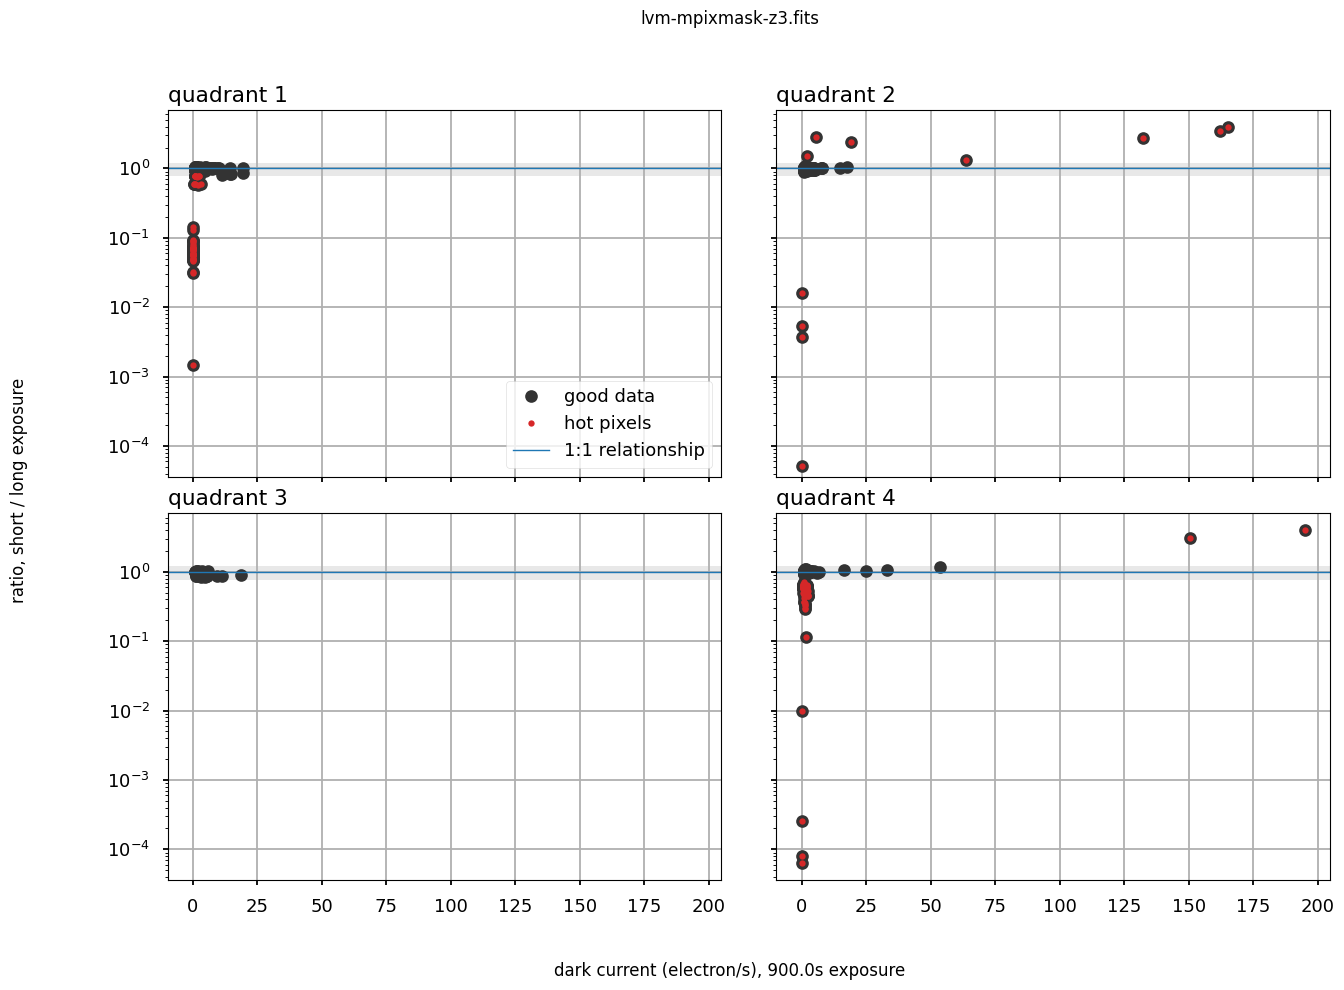

[INFO]: normalizing flats background with median_box = 20
[INFO]: normalizing flats by median: med_a = 1.00, med_b = 1.00
[INFO]: calculating ratio of flats: ratio_med = 1.00 [ratio_min = -16087.69, ratio_max = 13966.94
[INFO]: plotting flats histograms


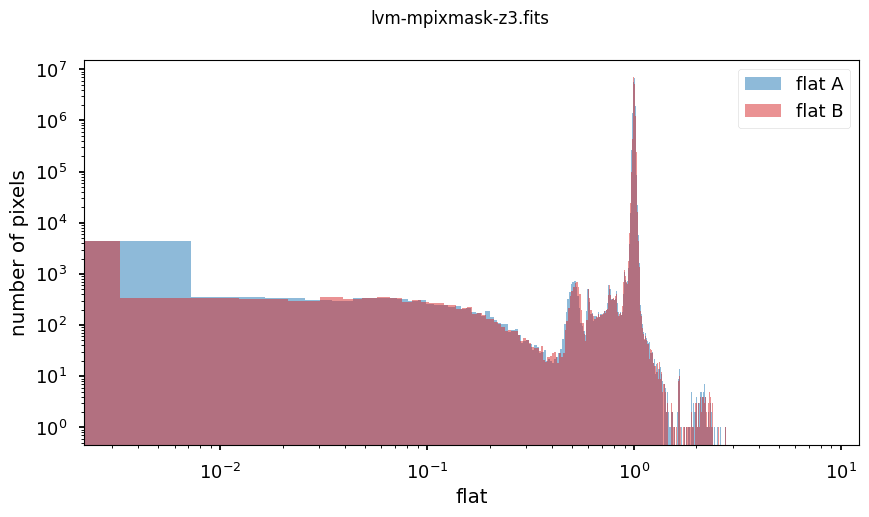

[INFO]: masking 25987 pixels in total (0.16%)
[INFO]: writing pixel mask to 'lvm-mpixmask-z3.fits'


In [6]:
dflat_dir = "data_pixflat"

short_exptime = 900
long_exptime = 3600

dflat_paths = sorted([os.path.join(dflat_dir, dflat) for dflat in os.listdir(dflat_dir) if "dpixflat" in dflat])
dflat_groups = groupby(dflat_paths, key=lambda s: os.path.basename(s).split("-")[2])

for camera, group in dflat_groups:
    medians = []
    group = list(group)
    # compute medians of all detrended pixel flats
    for dflat_path in group:
        medians.append(np.nanmedian(imageMethod.loadImage(dflat_path)._data))

    # sort paths by median values
    idx = np.argsort(medians)
    dflat_group = np.asarray(group)[idx]

    # pick two most different pixelflats
    flat_a = dflat_group[0]
    flat_b = dflat_group[-1]
    
    pixmask = imageMethod.create_pixelmask(in_short_dark=os.path.join(target_dir, f"lvm-mdark-{camera}-{short_exptime}s.fits"),
                                           in_long_dark=os.path.join(target_dir, f"lvm-mdark-{camera}-{long_exptime}s.fits"),
                                           in_flat_a=flat_a, in_flat_b=flat_b,
                                           out_pixmask=os.path.join(target_dir, f"lvm-mpixmask-{camera}.fits"), display_plots=True)